# Setup

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os


sys.path.insert(0, os.path.abspath('functions'))
sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import ind2sub, sub2ind3d
from sklearn.model_selection import train_test_split

import random
from collections import defaultdict

from math import log

import re
import time

print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-07-07 15:40:46.275118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Data Import

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)


cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

df18= pd.read_csv(cta30_18_path)
df19= pd.read_csv(cta30_19_path)
df20= pd.read_csv(cta30_20_path)
df21= pd.read_csv(cta30_21_path)
df22= pd.read_csv(cta30_22_path)

df_complete = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

df = df_complete.drop(['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)

df_a = df_complete[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]

df_a['VLV_RAF_REG_00'] = df_a['VLV_RAF_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)
df_a['VLV_SUR_REG_00'] = df_a['VLV_SUR_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)

df_a['VLV'] = 0 # colonna inizializzata a 0
for i in range(len(df)):
    if df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] == 0:
        df_a.loc[i, 'VLV'] = 0
    elif df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] != 0:
        df_a.loc[i, 'VLV'] = -1
    elif df_a['VLV_RAF_REG_00'][i] != 0 and df_a['VLV_SUR_REG_00'][i] == 0:
        df_a.loc[i, 'VLV'] = 1

df_a = df_a.drop(['VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)

df_rew = df_complete[['T_AMB_00', 'T_AMB_01', 'T_AMB_02', 'T_AMB_03', 'PW_ATT_M_00', 'T_M_SP_00']]

dir = '/Users/edoardorossi/Documents/GitHub/Tesi'
df.to_csv(os.path.join(dir, 'df.csv'), index=False)
df_a.to_csv(os.path.join(dir, 'df_a.csv'), index=False)
df_rew.to_csv(os.path.join(dir, 'df_rew.csv'), index=False)     


# print shapes of df and df_a and df_rew
print('df shape: ', df.shape)
print('df_a shape: ', df_a.shape)
print('df_rew shape: ', df_rew.shape)


## DF Loading

In [2]:
dir = '/Users/edoardorossi/Documents/GitHub/Tesi'
df = pd.read_csv(os.path.join(dir, 'df.csv'))
df_a = pd.read_csv(os.path.join(dir, 'df_a.csv'))
df_rew = pd.read_csv(os.path.join(dir, 'df_rew.csv'))

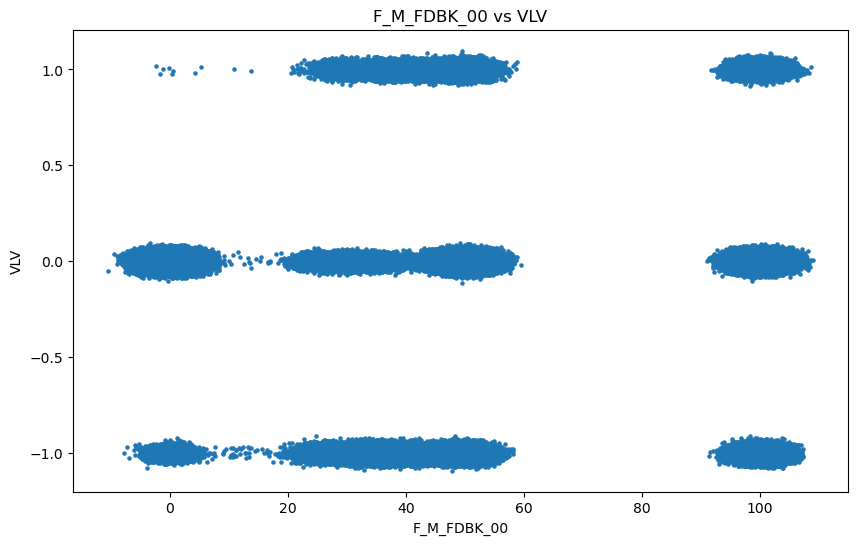

In [3]:
# Generare dei dati casuali con scala comune
x = df_a['F_M_FDBK_00']
y = df_a['VLV']

# Definire la deviazione standard del jitter per l'asse x e l'asse y
x_jitter_std = 2
y_jitter_std = 0.02

# Aggiungere jitter casuale alle coordinate x e y
x_jitter = x + np.random.normal(0, x_jitter_std, size=len(x))
y_jitter = y + np.random.normal(0, y_jitter_std, size=len(y))

# Plot scatter plot con jitter
plt.figure(figsize=(10,6))
plt.scatter(x_jitter, y_jitter, s=5)

# Personalizzazione grafico
plt.xlabel('F_M_FDBK_00')
plt.ylabel('VLV')
plt.title('F_M_FDBK_00 vs VLV')
plt.show()


# Preprocessing

## Normalization

In [4]:
path_scale_norm = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/scaler_norm.pkl'
try: 
    scale_norm = load_data(path_scale_norm)
    df_norm = pd.DataFrame(scale_norm.transform(df), columns=df.columns)
except:
    scale_norm = MinMaxScaler()
    df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)
    store_data(scale_norm, path_scale_norm)

print("The dataset has", df_norm.shape[1], "columns after normalization")

path_pca_norm = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/pca_norm.pkl'

try:
    pca = load_data(path_pca_norm)
    pca_norm = pd.DataFrame(pca.transform(df_norm))
    print("PCA loaded")
except:
    print("Computing PCA")
    pca = PCA(n_components=7)
    pca_norm = pd.DataFrame(pca.fit_transform(df_norm))
    store_data(pca, path_pca_norm)
    print("PCA computed")
print("The dataset has", pca_norm.shape[1], "columns after PCA")

df_a_norm = pd.DataFrame(scale_norm.fit_transform(df_a), columns=df_a.columns)


The dataset has 73 columns after normalization
PCA loaded
The dataset has 7 columns after PCA


## Standardization

In [23]:
path_scale_st = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/scaler_st.pkl'
try: 
    scale_st = load_data(path_scale_st)
    df_st= pd.DataFrame(scale_st.transform(df), columns=df.columns)
except:
    scale_st = MinMaxScaler()
    df_st = pd.DataFrame(scale_st.fit_transform(df), columns=df.columns)
    store_data(scale_st, path_scale_st)

path_pca_st = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/pca_st.pkl'
try:
    pca = load_data(path_pca_st)
    pca_st = pd.DataFrame(pca.transform(df_st), columns=df_st.columns)
except:
    pca = PCA(n_components=21)
    pca_st = pd.DataFrame(pca.fit_transform(df_st))
    store_data(pca, path_pca_st)
print("The dataset has", pca_st.shape[1], "columns after PCA")

df_a_st = pd.DataFrame(scale_st.fit_transform(df_a), columns=df_a.columns)




The dataset has 21 columns after PCA


# Clustering Analysis

## K-Means

### Stato

In [8]:
X = pca_st
k_min = 2
k_max = 50
step = 10
folder_name = 'fit_st_nuova'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl'):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

kmeans_2.pkl already exists


KMeans with 12 clusters computed in 36.67593002319336 seconds
KMeans with 22 clusters computed in 74.56236791610718 seconds
KMeans with 32 clusters computed in 83.6415958404541 seconds
KMeans with 42 clusters computed in 86.3450710773468 seconds


lista file: 
 ['kmeans_2.pkl', 'kmeans_5.pkl', 'kmeans_6.pkl', 'kmeans_8.pkl', 'kmeans_11.pkl', 'kmeans_14.pkl', 'kmeans_17.pkl', 'kmeans_20.pkl', 'kmeans_21.pkl', 'kmeans_23.pkl', 'kmeans_26.pkl', 'kmeans_32.pkl', 'kmeans_36.pkl', 'kmeans_47.pkl', 'kmeans_52.pkl', 'kmeans_72.pkl', 'kmeans_102.pkl', 'kmeans_142.pkl', 'kmeans_212.pkl', 'kmeans_282.pkl', 'kmeans_300.pkl', 'kmeans_400.pkl']
true x:  [2, 5, 6, 8, 11, 14, 17, 20, 21, 23, 26, 32, 36, 47, 52, 72, 102, 142, 212, 282, 300, 400]
true y:  [6056271.269453567, 2721335.595586062, 2311210.235453368, 1625136.297606707, 1038846.5817080557, 773610.0612551491, 622830.4380874616, 461044.5351515031, 423655.4708954777, 360853.70176349656, 292421.4637339052, 202383.42793376572, 162468.48549042537, 93801.88933970363, 71485.60383116816, 27992.21420543036, 7845.158919363419, 2305.0634777277987, 785.9769772190041, 412.22543180655384, 363.17435462410685, 207.5424066178197]


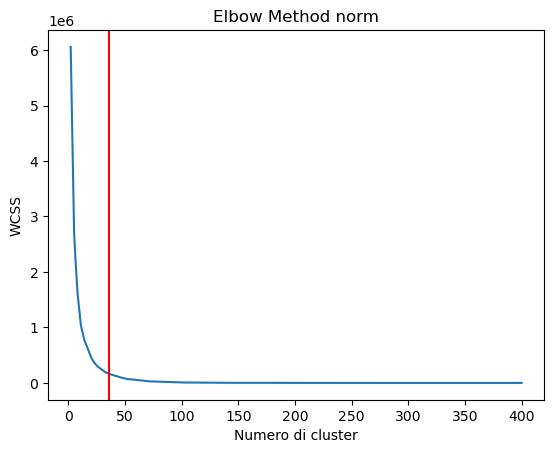

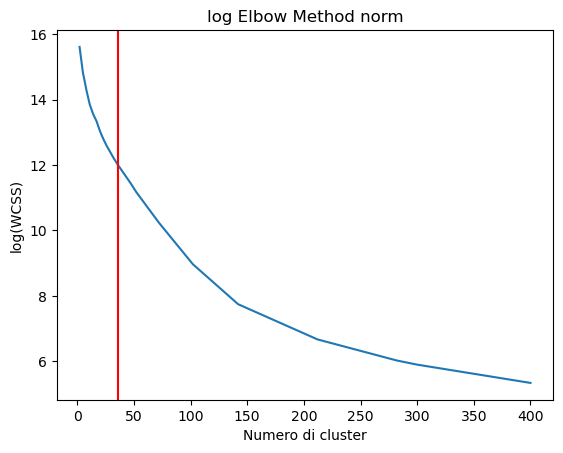

In [8]:
# ELBOW graph

from math import log

path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm'
file_list = os.listdir(path)

def ordina_file_per_numero(nome_file):
    prefisso = "kmeans_"
    suffisso = ".pkl"
    numero_str = nome_file[len(prefisso):-len(suffisso)]
    numero = int(numero_str)
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

x = []
y = []

print('lista file: \n', file_list_ordinata)

for i in range(len(file_list_ordinata)):

    # carica il file pkl
    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)
    
    #esegui la fit su pca_norm 
    #modello.fit(X)

    #assegna alla variabile x il numero di cluster
    x.append(modello.n_clusters)

    #assegna alla variabile y il valore di wcss 
    y.append(modello.inertia_)

do_it = False
if do_it:
    # itera finché y non è ordinata in modo decrescente
    while y != sorted(y, reverse=True):
        remove_index = []
        for i in range(len(y)-1):
            if y[i] < y[i+1]:
                # salva l'indice i in una variabile e aggiungila alla lista degli indici da rimuovere
                remove_index.append(i)
        for i in remove_index:
            del x[i]
            del y[i]

print('true x: ', x)
print('true y: ', y)
        

elbow = 36
plt.plot(x,y)
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm')
plt.show()

plt.plot(x,[log(i) for i in y])
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('log(WCSS)')
plt.title('log Elbow Method norm')
plt.show()


### Azione

In [22]:
X = df_a_norm
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl'):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")



KMeans with 2 clusters computed in 3.7340500354766846 seconds
KMeans with 3 clusters computed in 4.133567810058594 seconds
KMeans with 4 clusters computed in 4.312129020690918 seconds
KMeans with 5 clusters computed in 5.659183979034424 seconds
KMeans with 6 clusters computed in 5.926606178283691 seconds
KMeans with 7 clusters computed in 8.034204959869385 seconds
KMeans with 8 clusters computed in 9.640599966049194 seconds
KMeans with 9 clusters computed in 10.025261878967285 seconds
KMeans with 10 clusters computed in 12.694108963012695 seconds


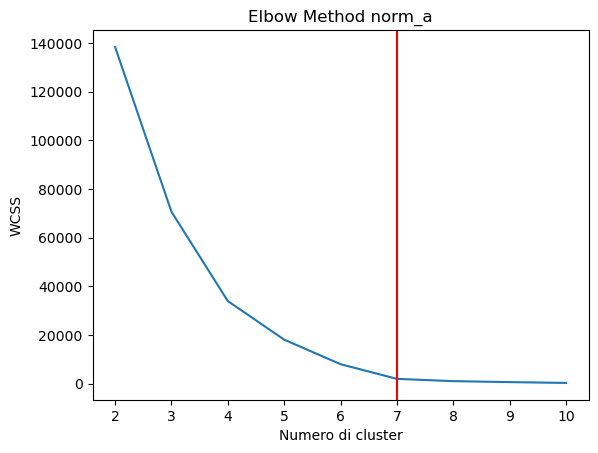

Elbow method finds the best number of clusters at 7 clusters


In [24]:

#for each kmeans_i in folder fit_norm_a compute the elbow method
folder_name = 'fit_norm_a'
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/{}'.format(folder_name)
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    #se il file inizia con kmeans_
    if nome_file.startswith("kmeans_"):
        numero = int(nome_file.split("_")[1].split(".")[0])
        return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("kmeans_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()


plt.plot(kmeans_nums, wcss)
elbow = 7
#plot a red vertical line at the elbow
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a')
plt.show()
print('Elbow method finds the best number of clusters at', elbow, 'clusters')

# Model Generation

## Clustering Generation

In [14]:
X = pca_norm
XX = df_a_norm
df_pos = df_norm
n_clusters = 212
n_actions = 9

try:
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm/kmeans_{}.pkl'.format(n_clusters), 'rb') as f:
        clustering_model = pickle.load(f)
        print(clustering_model.n_clusters)
except:
    clustering_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clustering_model.fit(X)
    
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm/kmeans_{}.pkl'.format(n_clusters), 'wb') as f:
        pickle.dump(clustering_model, f)

try:
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm_a/kmeans_a_{}.pkl'.format(n_actions), 'rb') as f:
        clustering_model_actions = pickle.load(f)
        print(clustering_model_actions.n_clusters)
except:
    clustering_model_actions = KMeans(n_clusters=n_actions, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clustering_model_actions.fit(XX)
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm_a/kmeans_a_{}.pkl'.format(n_actions), 'wb') as f:
        pickle.dump(clustering_model_actions, f)

#print centroids of actions
print('centroids of actions: \n', clustering_model_actions.cluster_centers_)
print('X shape: ', X.shape)

df_pos['cluster'] = clustering_model.predict(X)
df_pos['action_clustered'] = clustering_model_actions.predict(XX)
number_of_clusters = len(clustering_model.cluster_centers_)
number_of_actions = len(clustering_model_actions.cluster_centers_)

df_mdp_norm = pd.DataFrame(columns=['S','At'])
df_mdp_norm['S'] = df_pos['cluster']
df_mdp_norm['At'] = df_pos['action_clustered']

save_path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/df_mdp_norm_' + str(n_clusters)+'_a'+ str(n_actions)+'.csv'
df_mdp_norm.to_csv(save_path, index=False)
print(save_path)

212


centroids of actions: 
 [[ 9.96617187e-01  5.00000000e-01]
 [ 2.47551618e-06  5.00000000e-01]
 [ 4.98242381e-01  5.00000000e-01]
 [ 3.29402802e-01  2.58681965e-13]
 [ 4.53014028e-01  1.00000000e+00]
 [ 9.96599958e-01 -9.18709553e-14]
 [ 9.96572427e-01  1.00000000e+00]
 [ 4.91382722e-01 -8.63198402e-14]
 [ 3.04987143e-01  5.00000000e-01]]
X shape:  (2176378, 7)
/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/df_mdp_norm_212_a9.csv


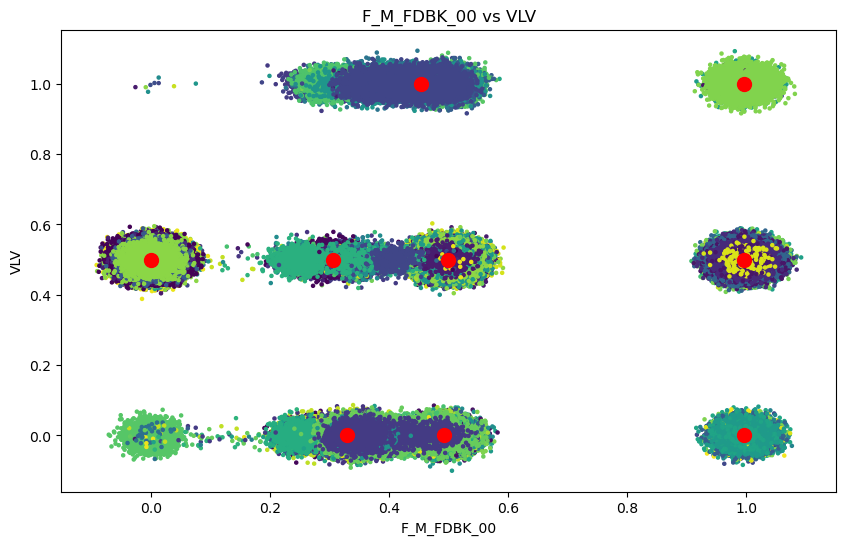

In [16]:
# Generare dei dati casuali con scala comune
x = df_a_norm['F_M_FDBK_00']
y = df_a_norm['VLV']
c = df_pos['cluster']

# Aggiungere jitter casuale alle coordinate x e y
x_jitter = x + np.random.normal(0, 0.02, size=len(x))
y_jitter = y + np.random.normal(0, 0.02, size=len(y))

# Plot scatter plot con jitter
plt.figure(figsize=(10,6))
plt.scatter(x_jitter, y_jitter, s=5, c=c, cmap='viridis')

# Plot centroidi dei cluster
plt.scatter(clustering_model_actions.cluster_centers_[:,0], clustering_model_actions.cluster_centers_[:,1], s=100, c='red', marker='o')

# Personalizzazione grafico
plt.xlabel('F_M_FDBK_00')
plt.ylabel('VLV')
plt.title('F_M_FDBK_00 vs VLV')
plt.show()